In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import random

In [3]:
#Define our constants
class Water:
    
    density = 998.29
    mass = 0.21#0.04
    viscosity = 3.5
    surface_tension = 0.0728
    threshold = 7.065
    stiffness = 3
    radius = 0.1
    
#Class to hold Particle
class Particle:
    def __init__(self,x,y, color=1):
        self.r = np.array([x,y])
        self.v = np.array([0.,0.])
        
        self.pres = 101325
        self.smooth_c = 0
        self.n = 0
        self.pressure = 101325
        
        #Color optional, useful for two phase simulations
        if color == 1:
            self.rho = Water.density
            self.mass = Water.mass
            self.color = 1
        elif color == 0:
            self.rho = 0.7*Water.density
            self.mass = 0.7*Water.mass
            self.color = 0
        else:
            self.rho = Water.density
            self.mass = Water.mass
            self.color = -1
        

In [4]:
#Define our Kernel functions
#I'm just using cubic splines, which is probably not optimal
#But it's simple and works.


def cubic_spline(R, h=Water.radius):
    q = np.sqrt(np.dot(R, R)) / h
    sigma = 10/(7*np.pi)
    if q >= 2:
        return 0
    elif q >=1:
        return 0.25*sigma*(2-q)**3
    else:
        return sigma*(1 - 1.5*q**2 + 0.75*q**3)

def grad_cubic_spline(R, h=Water.radius):
    r = np.sqrt(np.dot(R,R))
    direc = R / r
    q = r/h
    sigma = 10/(7*np.pi)
    if q >= 2:
        return np.array([0.,0.])
    elif q >=1:
        return (-sigma*0.75*(2-q)**2) * direc
    else:
        return (-3*q +9/4*q**2)*sigma*direc
    
def laplace_cubic_spline(R, h=Water.radius):
    r = np.sqrt(np.dot(R,R))
    direc = R / r
    q = r/h
    sigma = 10/(7*np.pi)
    if q >= 2:
        return np.array([0.,0.])
    elif q >=1:
        return (sigma*2*0.75*(2-q))
    else:
        return (-3 +9/2*q)*sigma
    

In [5]:
PARTICLES = []
#Generate a starting configuration of particles
#Right now, this is generating a column of water
for i in range(500):
    x,y = random.uniform(0,0.25),random.uniform(0,0.5)
    PARTICLES.append(Particle(x,y,1))

In [6]:
#The main event, simulate a timestep of length dt
def step(dt):
    for i, pi in enumerate(PARTICLES):
        density = 0
        smooth_color=0
        if pi.color < 0: #Ignore any 'ghost' boundary particles
            continue
        for j, pj in enumerate(PARTICLES):
            if i==j:
                continue
            rij = pi.r - pj.r
            #Calculate smoothed density and color fields
            density += pj.mass* cubic_spline(rij)
            smooth_color += pj.color*cubic_spline(rij)
        pi.smooth_c = smooth_color    
        pi.rho = density
        #Calculate pressure based on density and ideal gas equation
        #Should try Tait eqn. in the future
        pi.pressure = Water.stiffness*(pi.rho - Water.density)
        
        f_pres = np.array([0.,0.])
        f_visc = np.array([0.,0.])
        f_grav = np.array([0.,-9.8])
        f_surf = np.array([0.,0.])
        for j,pj in enumerate(PARTICLES):
            if i==j:
                continue
            rij = pi.r - pj.r
            if np.dot(rij, rij) > (Water.radius)**2:
                continue
            try:
                term1, term2 = (pi.rho + pj.rho)/(pi.rho**2 + pj.rho**2), grad_cubic_spline(rij)
                f_pres -= term1*term2
            except ZeroDivisionError:
                f_pres += np.array([0.,0.])
            f_visc += Water.viscosity * pj.mass * (pj.v - pi.v)/pj.rho * laplace_cubic_spline(rij)
        
        K_wall = 0.01
        wallx, wally = 0,0
        
        #Wall repulsive forces
        #This inverse square force doesn't work very well
        #Too easy to impart huge velocities
        '''
        if pi.r[0] < 0.1:
            wallx = K_wall/(pi.r[0]**2)
        elif pi.r[0] > 0.90:
            wallx = -K_wall/(1-pi.r[0])**2
        if pi.r[1] < 0.1:
            wally = K_wall/(pi.r[1]**2)
        elif pi.r[1] > 0.90:
            wally = -K_wall/(1-pi.r[1])**2
        '''
        f_wall = np.array([wallx, wally])
        #step velcoties and positions
            
        #Simple Euler integration
        #Should evenutally replace with Verlet, leapfrog or other scheme
        a = (f_pres + f_visc + f_grav )/ pi.mass
        newv = pi.v + a*dt
        newr = pi.r + pi.v*dt
        
        #Keep all particles inside the box, bounded by 0 and 0.5
        for k in range(2):
            if newr[k] <0:
                newr[k] = 0.01
                newv[k] = -0.7*newv[k] #I assume bouncing off the wall isn't perfectly inelastic
            elif newr[k] > .5:
                    newr[k] = 0.49
                    newv[k] = -0.7*newv[k]
        
        pi.v = newv
        pi.r = newr

(0, 0.6)

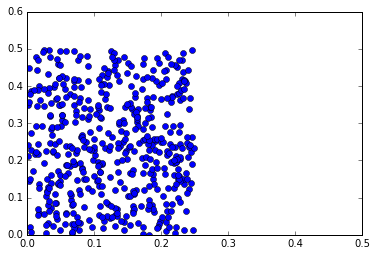

In [7]:
#Plot our initial config
plt.plot([x.r[0] for x in PARTICLES], [x.r[1] for x in PARTICLES], 'o')
plt.xlim(0,0.5)
plt.ylim(0,0.6)

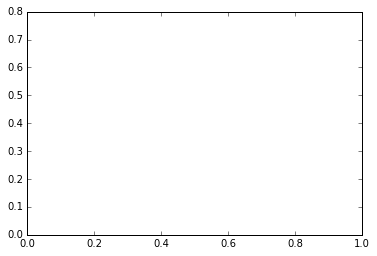

In [8]:
#Set up for the animation
fig, ax = plt.subplots()
ax.set_xlim(( 0, 1))
ax.set_ylim((0, 0.8))
line, = ax.plot([], [], 'o')
def init():
    line.set_data([], [])
    return (line,)
def animate(i):
    if i % 100 == 0:
        print(i)  #Just to give me some indication of progress
    step(0.0005)
    x,y = [x.r[0] for x in PARTICLES], [x.r[1] for x in PARTICLES]
    line.set_data(x, y)
    return (line,)

In [9]:
#I wish I could embed and save the video at the same time
#Right now, I have to pick one or the other

#With 500 particles, one step takes about 3 seconds
#So 400 frames should take about 20 minutes?
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=20, blit=True)
#anim.save('slosh_2.mp4', fps=25, extra_args=['-vcodec', 'libx264'])
HTML(anim.to_html5_video())

0
100
200
300


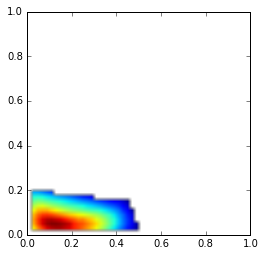

In [10]:
#And for funsies, a nice heatmap of the pressure

import scipy.interpolate

x,y,z = [a.r[0] for a in PARTICLES], [a.r[1] for a in PARTICLES], [a.pressure for a in PARTICLES]
xi, yi = np.linspace(0, 1),np.linspace(0, 1)
xi, yi = np.meshgrid(xi,yi)
zi = scipy.interpolate.griddata((x,y),z,(xi,yi), method='linear')

plt.imshow(zi, vmin=min(z), vmax=max(z), origin='lower',
           extent=[0,1, 0, 1])